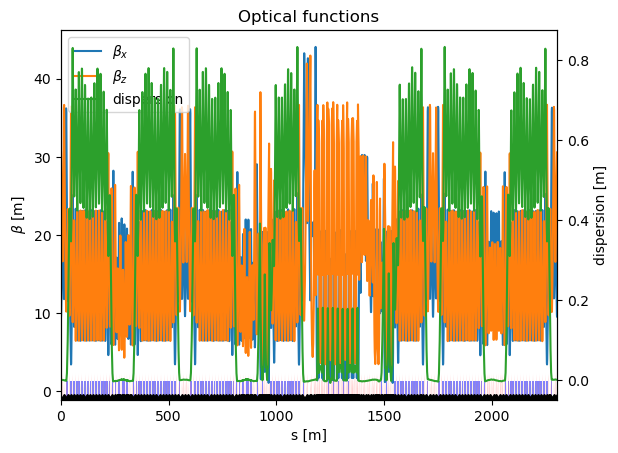

The lattice p3_v24 has 246 BPMs both planes Hor and Ver , 438 Correctors, 230 Sextupoles, and 417 quadrupoles with 193 quads families and 16 skew quads. Number of used correctors = 219 Hor and = 194 Ver
The ideal lattice tune values: [37.12799969 30.27187036], The chromaticity values: [-0.19327199 -0.1516299 ]. 


In [1]:
import numpy as np

from at_modules_loco import *
from data_loader import load_data,load_indices

# load lattice
lattice_name = 'p3_v24'
ring = at.load_mat(lattice_name)
ring.plot_beta()
ring.radiation_off()
ring0 = deepcopy(ring)

#ring.radiation_on()
#ring.enable_6d()
#at.set_rf_frequency(ring)
#at.set_cavity_phase(ring)

#Loading data & parameters

C_measured, C_model, Noise_BPMx, Noise_BPMy, BPM_names, HCM_names, VCM_names, Jn = load_data(ring)
quads_indices, skew_indices,quad_fam_names, quads_fam_indices, bpm_indices, corrector_indices, dipole_indices,hcm_index,vcm_index,sext_indexes, bpm_x_ind, bpm_y_ind,nominal_crom, nominal_tune = load_indices(ring)
Jn = Full_Jacobian(Jn , C_model, hcm_index, vcm_index, bpm_x_ind, bpm_y_ind)

[elemdata0, beamdata, elemdata] = at.get_optics(ring, bpm_indices)
twiss = elemdata
print('The lattice {} has {} BPMs both planes Hor and Ver , {} Correctors, {} Sextupoles, and {} quadrupoles with {} quads families and {} skew quads. Number of used correctors = {} Hor and = {} Ver'.format(lattice_name, len(BPM_names), len(HCM_names)+len(HCM_names),  len(sext_indexes), len(quads_indices), len(quads_fam_indices),len(skew_indices),len(HCM_names), len(VCM_names)))
print(f"The ideal lattice tune values: {nominal_tune}, "
      f"The chromaticity values: {nominal_crom}. ")

# quads and correctors kick
correctors_kick = 50.e-6
dk = 1.e-4

# Model ORM & Jacobian

#C_model = model_orm(correctors_kick, ring,  hcm_index, vcm_index, bpm_x_ind,bpm_y_ind, includeDispersion=False, include_coupling=True)
#Jn = calculate_jacobian(ring, quads_fam_indices, C_model, correctors_kick, hcm_index ,vcm_index, bpm_x_ind, bpm_y_ind, dk
#                      , includeDispersion=False,include_coupling = True,
#                       skew=False, family=True, full_jacobian=True)

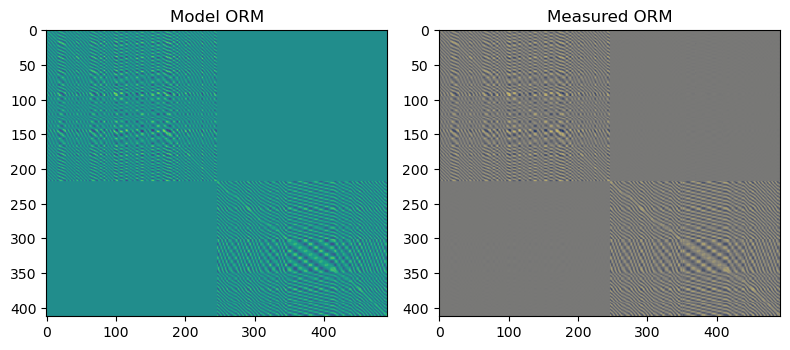

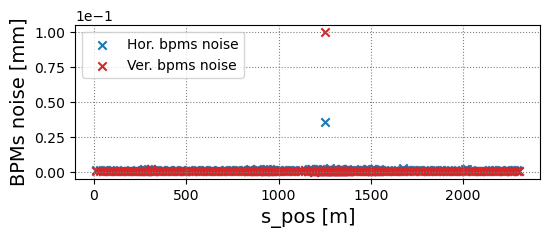

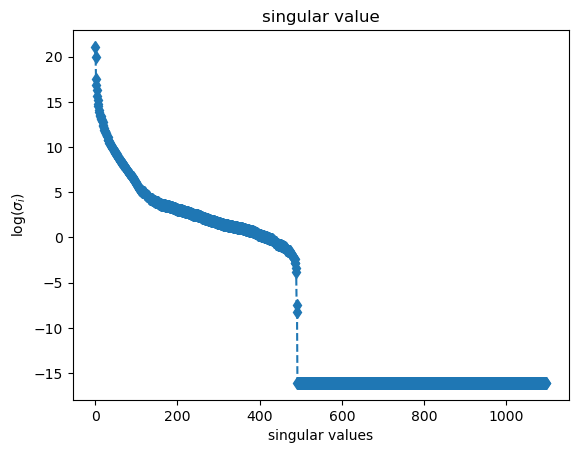

In [2]:
C_measured =  C_measured *10
plot_orm(C_model, C_measured)
Weight= weight_matrix(ring, Noise_BPMx, Noise_BPMy, show_plot=True)

# Choose pararmeters to fit

total_length = len(quads_fam_indices) + len(hcm_index) + len(vcm_index) + len(bpm_x_ind) + len(bpm_y_ind)
lengths = [len(quads_fam_indices) ,len(hcm_index) + len(vcm_index),  len(bpm_x_ind) + len(bpm_y_ind)]
including_fit_parameters = ['quads', 'cor', 'bpm']

# Initial guess of fit parameters

initial_guess = np.zeros(total_length)
initial_guess[:lengths[0]]= 1e-6 #quads
initial_guess[lengths[0]:lengths[0] + lengths[1] ]= 1e-6 # cor
initial_guess[lengths[0] + lengths[1] :] = 1e-6 # bpms

LOCO iteration 0
 BPM_to_corrector_response_matrices (Measured) ..


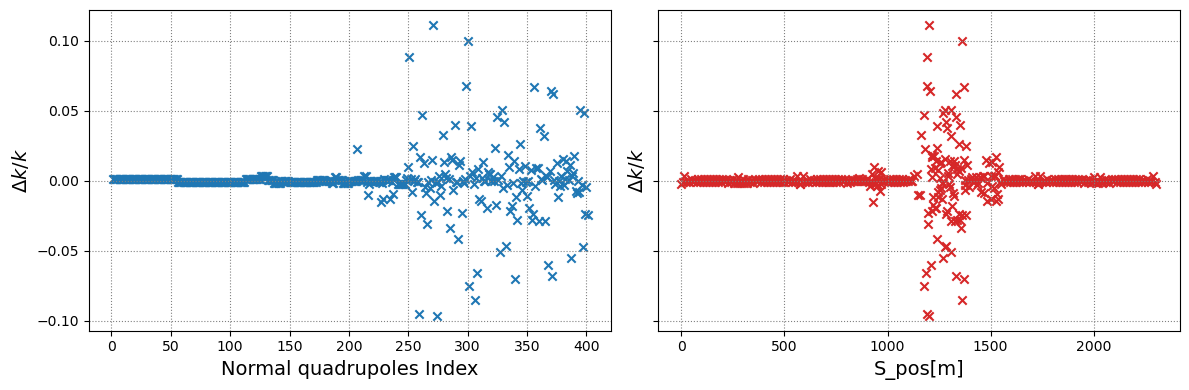

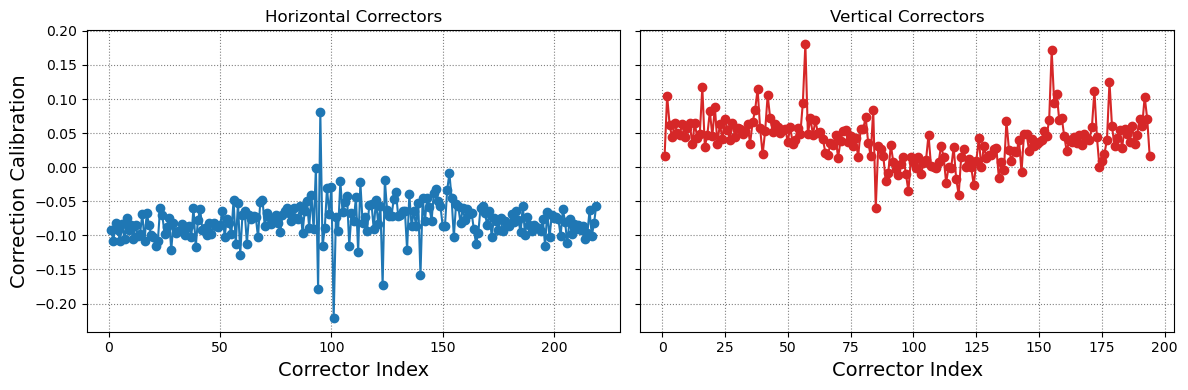

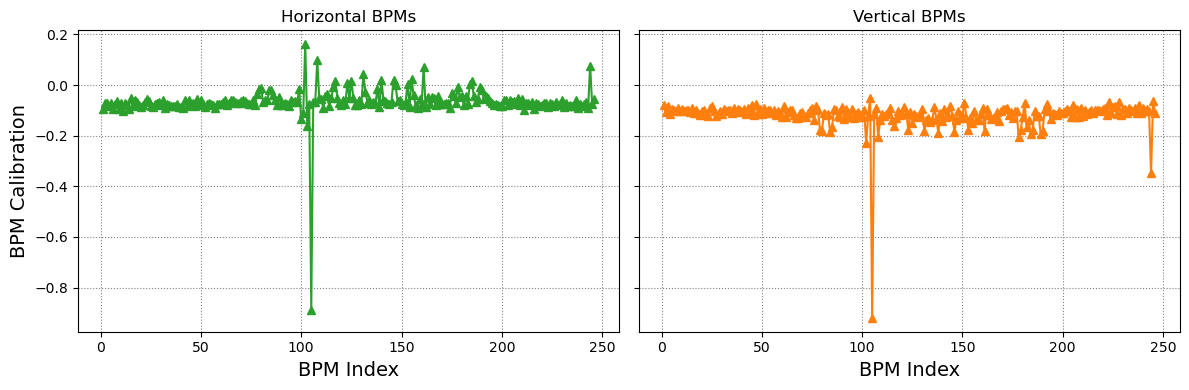

Beta beating after corrections
RMS Beta-beating predicted by LOCO 'LM algorithm' using all normal quads families and cal:22.57871022392863 % horizontal 28.518588452959666 %


In [3]:
n_iter = 1

initial_guess0 =initial_guess
for x in range(n_iter):
    print(f'LOCO iteration {x}')


    print(" BPM_to_corrector_response_matrices (Measured) ..")   # Loaded before

    fit_parameters = loco_correction_lm(initial_guess, C_model, C_measured,  Jn, lengths,
                                               including_fit_parameters, bounds=(-0.03, 0.03), weights=Weight, verbose=2)

    #fit_parameters = np.loadtxt('fit_parameters_lm_coup_l')

    quad_strength = fit_parameters[:lengths[0]]
    cor_cal = fit_parameters[lengths[0]:lengths[0] + lengths[1] ]
    bpm_cal = fit_parameters[lengths[0] + lengths[1] :]

    plot_fit_parameters(ring, ring0, quads_fam_indices, fit_parameters, lengths, including_fit_parameters, hcm_index, vcm_index,
                        bpm_x_ind, bpm_y_ind)

    setCorrection(ring, quad_strength, quads_fam_indices,
                  add=False, skew=False, family=True)  # Note: For PETRA III examples the fit parameters were aded to the model lattice (option add = False)

    print('Beta beating after corrections')
    bx_rms_cor, by_rms_cor = model_beta_beat(ring, twiss, bpm_indices, plot = False)

    print(f"RMS Beta-beating predicted by LOCO 'LM algorithm' using all normal quads families and cal:{bx_rms_cor*100} % horizontal {by_rms_cor*100} %")


    #print(f"RMS Beta-beating predicted by LOCO 'LM algorithm' using all normal quads families and cal:17:04 % horizontal 30.13 %")
